In [1]:
%matplotlib inline
%pylab inline
from utils import *

# Settings
input_dim = 99 #89-2 #27*2
output_dim = 0
nseqlen = 128
#fdir = "/media/lukasz/TOSHIBA EXT/csv-hee"
test_dir = "/media/lukasz/DATA/test"

# Load data
inputs, outputs, ids = load_data(test_dir, input_dim, 2, nseqlen, nsamples = 10000)

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


model-1-32-2.json 0.00279647722752


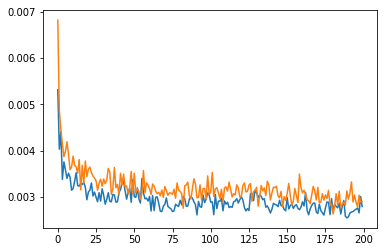

model-1-64-0.json 0.00277869508041


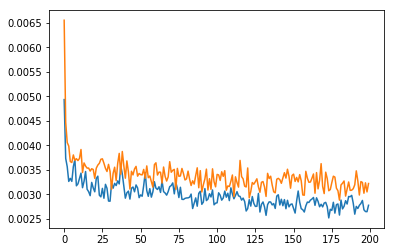

model-1-32-0.json 0.00271450562644


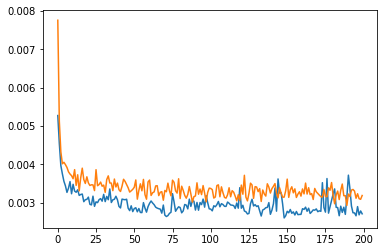

model-0-64-0.json 0.00367125686577


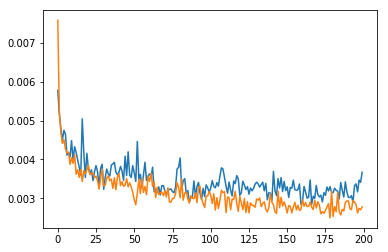

model-1-64-2.json 0.00280946574345


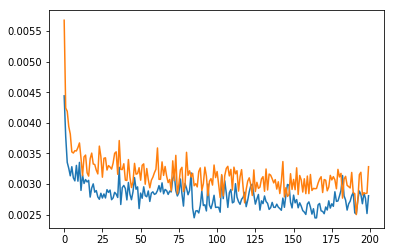

model-0-32-2.json 0.00299486010762


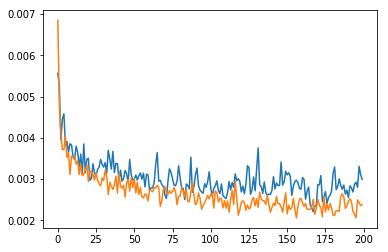

model-1-16-0.json 0.00285506696775


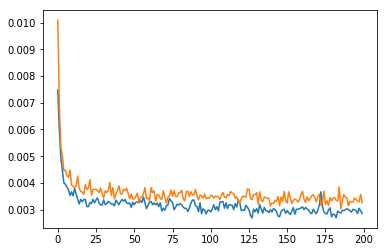

model-0-64-1.json 0.00310597603914


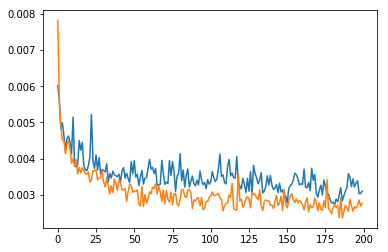

model-0-32-0.json 0.00307400964102


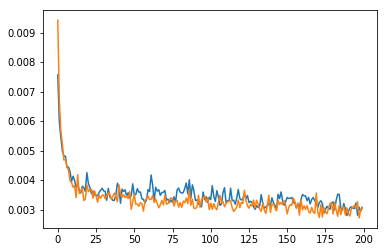

model-1-64-1.json 0.00289159366918


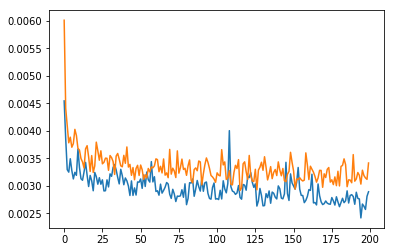

model-0-64-2.json 0.00272441926509


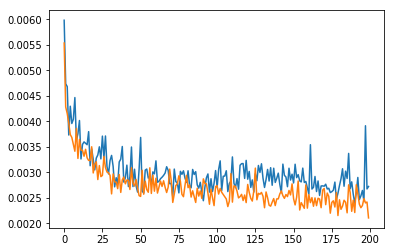

model-1-32-1.json 0.00272816337093


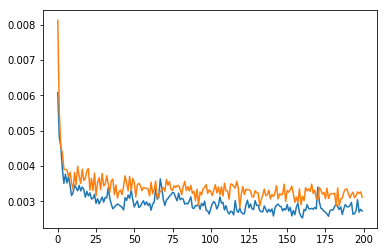

model-1-16-2.json 0.0027433118187


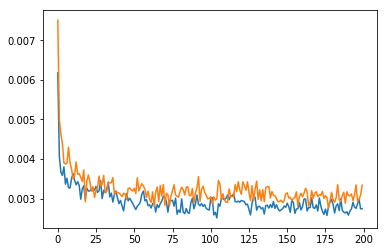

model-0-32-1.json 0.00346934313738


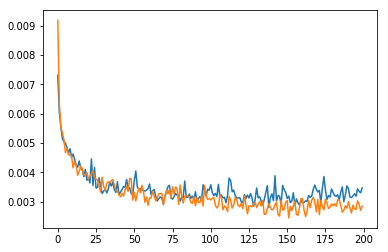

model-0-16-2.json 0.00246427757064


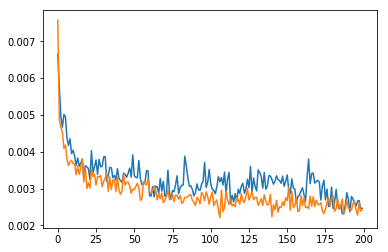

model-0-16-0.json 0.00342770357334


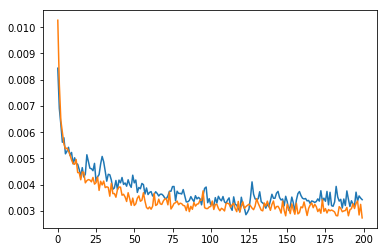

model-0-16-1.json 0.00444163509282


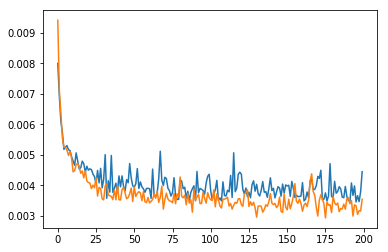

model-1-16-1.json 0.00370132776166


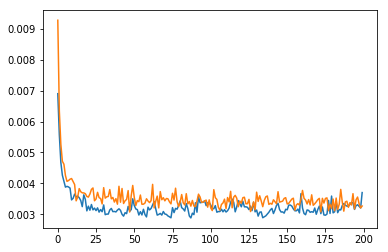

In [2]:
output_dim = 0
for filename in os.listdir("models"):
    if not filename.endswith(".json"): 
        continue
    import json
    with open("models/" + filename, 'r') as infile:
        data = json.load(infile)
        print("%s %s" % (filename, data["history"]["val_loss"][-1]))
        plt.plot(data["history"]["val_loss"])
        plt.plot(data["history"]["loss"])
        plt.show()

In [3]:
n = inputs.shape[0]
ntrain = int(math.floor(n * 0.9))
print(ntrain)

peaks = [[0,1], [2,2], [2,0]]
index, value = max(enumerate(peaks), key=lambda x: x[1][1])
print(index)

1446
1


In [4]:
from keras.models import load_model
import keras
from numpy import mean
from utils import weighted_binary_crossentropy

keras.losses.weighted_binary_crossentropy = weighted_binary_crossentropy
model = load_model("models/model-%d-64-2.h5" % output_dim)
#model = load_model("models-old/model-48-3-hee.h5")

[(0, array([   0.        , -249.78634262])), (1, array([  51.       ,  271.8236084]))]


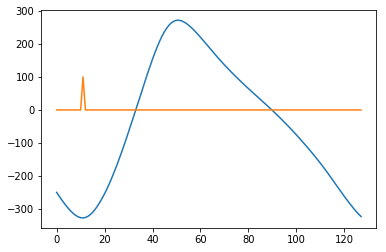

In [5]:
subj = 69
plt.plot(inputs[subj][:,42 - 9])

print(list(enumerate(peakdet(inputs[subj][:,42 - 9],0.5)[0])))
plt.plot(outputs[subj][:,1] * 100)

Error distribution:
<= 1: 0.742094
<= 3: 0.945889
<= 5: 0.973999
<= 10: 0.995081
<= 60: 1.000000
Mean distance: 1.217850
0.0159059474412


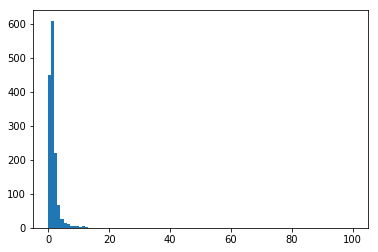

In [6]:
def peak_cmp(annotated, predicted):
    dist = []
    predicted = [k for k in predicted if (k >= 10 and k < 128-10)]
    annotated = [k for k in annotated if (k >= 10 and k < 128-10)]
    
    if (len(predicted) != len(annotated)):
#        print(predicted, annotated)
        return -1
    if len(predicted) == 0 or len(annotated) == 0:
        return 0
    
    for a in annotated:
#        if a > 120:
#            continue
        dist = dist + [min(np.abs(predicted - a))]
    if not len(dist) or (mean(dist) > 30):
        return -1
    return mean(dist)

def eval_prediction(likelihood, true, patient, plot = True, shift = 0, thresh = 0.7):
    sdist = []
    
    peakind = peakdet(likelihood[:,0], thresh)
    for k,v in peakind[0]:
        if plot:
            plt.axvline(x=k)
    sdist.append(peak_cmp(np.where(true[:,0] > 0.5)[0], [k + shift for k,v in peakind[0]]))
        
#    peakind = peakdet(likelihood[:,1],0.5)
#    for k,v in peakind[0]:
#        if plot:
#            plt.axvline(x=k)
#    sdist.append(peak_cmp(np.where(true[:,1] > 0.5)[0], [k for k,v in peakind[0]]))

    if plot:
        plt.plot(likelihood) # continous likelihood process
        plt.plot(true) # spikes on events
        plt.title(patient)
        axes = plt.gca()
        axes.set_xlim([0,true.shape[0]])
        plt.show()
    return sdist

#cols = range(15) + [30 + i for i in range(6)] + [54 + i for i in range(6)] + [12 + 81 + i for i in range(6)] 
cols = range(15) + [60 + i for i in range(12)] + [12 + 81 + i for i in range(6)]
cols = range(15) + [60 + i for i in range(13)] + [12 + 81 + i for i in range(6)] # with
res = model.predict(inputs[0:ntrain,:,cols])
sdist = []

for ntrial in range(ntrain):
    likelihood = res[ntrial,:,:]
    true = outputs[ntrial,:,(output_dim):(output_dim+1)]
    d = eval_prediction(likelihood, true, ids[ntrial], plot = False, shift = 0)
    sdist.extend(d)
plot_stats(sdist)
print(len([k for k in sdist if ((k > 30) or (k < 0))]) / float(len(sdist)))

sdist_our = sdist

Error distribution:
<= 1: 0.405646
<= 3: 0.760773
<= 5: 0.921991
<= 10: 0.987370
<= 60: 1.000000
Mean distance: 2.442051
0.0691562932227
Error distribution:
<= 1: 0.463190
<= 3: 0.828221
<= 5: 0.940951
<= 10: 0.987730
<= 60: 1.000000
Mean distance: 2.161810
0.0982019363762


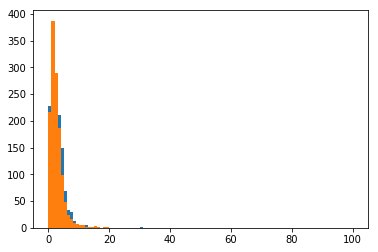

In [7]:
# 30
# 46
def coordinate_pred(inputs, nseqlen, output_dim = 0):
    outputs = np.zeros((inputs.shape[0], inputs.shape[1], 1))

    for i in range(inputs.shape[0]):
        try:
            if output_dim == 0:
                peaks = peakdet(inputs[i][:,42],0.5)[0]
                index, value = max(enumerate(peaks), key=lambda x: x[1][1])
            if output_dim == 1:
                peaks = peakdet(inputs[i][:,42],0.5)[1]
                index, value = max(enumerate(peaks), key=lambda x: x[1][1])
            
            
            outputs[i,int(peaks[index][0]),0] = 1
        except:
            pass
        
    return outputs

def velocity_pred(inputs, nseqlen, output_dim = 0):
    outputs = np.zeros((inputs.shape[0], inputs.shape[1], 1))

    for i in range(inputs.shape[0]):
        try:
            v = inputs[i][:,63] #+9
            v = np.sign(v)
            if output_dim == 0:
                k = np.where(-2 == v[1:] - v[:-1])
            if output_dim == 1:
                k = np.where(2 == v[1:] - v[:-1])
            k = k[0]
            for j in k:
                outputs[i,j,0] = 1
            # k = peakdet(v,0.5)[0][1][0]
        except:
            pass
        
    return outputs

def plot_stats(sdist):
    plt.hist(sdist,100,[0, 100])
    filtered = [k for k in sdist if k >= 0]
    
    def off_by(threshold, filtered):
        ob = [k for k in filtered if k <= threshold]
        nel = float(len(filtered))
        print("<= %d: %f" % (threshold, len(ob) / float(nel)))
        
    
    print("Error distribution:")
    off_by(1, filtered)
    off_by(3, filtered)
    off_by(5, filtered)
    off_by(10, filtered)
    off_by(60, filtered)
    print("Mean distance: %f" % (np.mean(filtered)))
 

res = velocity_pred(inputs, 128, output_dim)
sdist = []
for ntrial in range(ntrain):
    likelihood = res[ntrial,:,:]
    true = outputs[ntrial,:,(output_dim):(output_dim+1)]
    d = eval_prediction(likelihood, true, ids[ntrial], plot = False, shift = 3)
    sdist.extend(d)
plot_stats(sdist)
#plot_stats(sdist)
#print(sdist)
print(len([k for k in sdist if ((k > 30) or (k < 0))]) / float(len(sdist)))

res = coordinate_pred(inputs, 128, output_dim)
sdist = []
for ntrial in range(ntrain):
    likelihood = res[ntrial,:,:]
    true = outputs[ntrial,:,(output_dim):(output_dim+1)]
    d = eval_prediction(likelihood, true, ids[ntrial], plot = False, shift = 3)
    sdist.extend(d)
plot_stats(sdist)
print(len([k for k in sdist if ((k > 30) or (k < 0))]) / float(len(sdist)))
#plot_stats(sdist)


Error distribution:
<= 1: 0.742094
<= 3: 0.945889
<= 5: 0.973999
<= 10: 0.995081
<= 60: 1.000000
Mean distance: 1.217850 (sd = 1.533296)
Error distribution:
<= 1: 0.405646
<= 3: 0.760773
<= 5: 0.921991
<= 10: 0.987370
<= 60: 1.000000
Mean distance: 2.442051 (sd = 2.373310)
Error distribution:
<= 1: 0.463190
<= 3: 0.828221
<= 5: 0.940951
<= 10: 0.987730
<= 60: 1.000000
Mean distance: 2.161810 (sd = 2.183116)


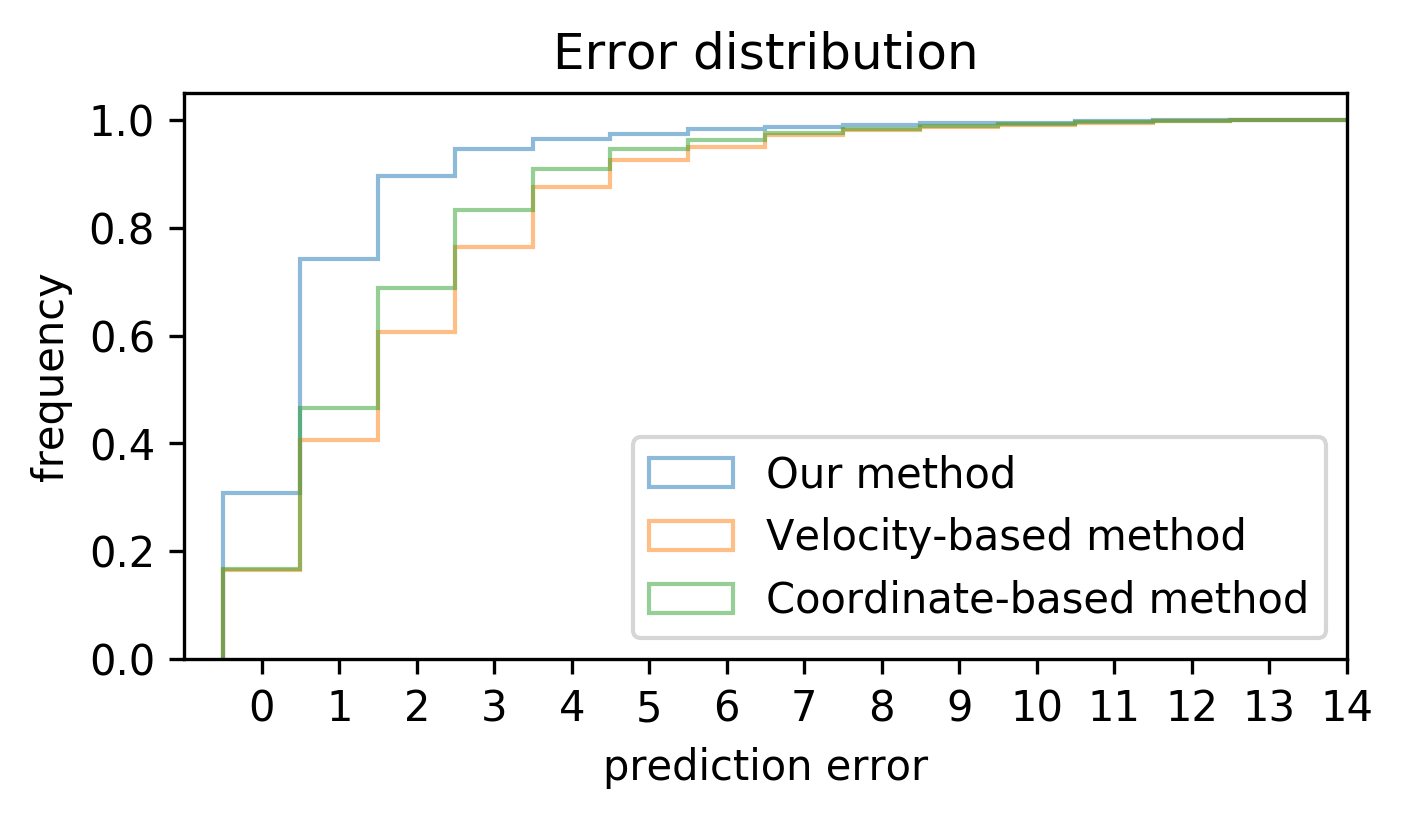

In [28]:
import math

axes = plt.gca()
axes.set_xlim([-1,12])

def plot_stats(sdist,name=""):
    plt.hist(sdist,bins=np.arange(16) - 0.5,range=(0,15),
             alpha=0.5,normed=True,label=name,
             cumulative=True, histtype='step', stacked=True,)

    filtered = [k for k in sdist if (k >= 0 and k <= 30)]
    
    def off_by(threshold, filtered):
        ob = [k for k in filtered if k <= threshold]
        nel = float(len(filtered))
        print("<= %d: %f" % (threshold, len(ob) / float(nel)))
        
    
    print("Error distribution:")
    off_by(1, filtered)
    off_by(3, filtered)
    off_by(5, filtered)
    off_by(10, filtered)
    off_by(60, filtered)
    print("Mean distance: %f (sd = %f)" % (np.mean(filtered),np.std(filtered)))
 
plt.rcParams['figure.figsize'] = (5, 2.5)
plot_stats(sdist_our,name="Our method")

res = velocity_pred(inputs, 128, output_dim)
sdist = []
for ntrial in range(ntrain):
    likelihood = res[ntrial,:,:]
    true = outputs[ntrial,:,(output_dim):(output_dim+1)]
    d = eval_prediction(likelihood, true, ids[ntrial], plot = False, shift = 3)
    sdist.extend(d)
plot_stats(sdist,name="Velocity-based method")
#plot_stats(sdist)
#print(sdist)
sdist_vel = sdist

res = coordinate_pred(inputs, 128, output_dim)
sdist = []
for ntrial in range(ntrain):
    likelihood = res[ntrial,:,:]
    true = outputs[ntrial,:,(output_dim):(output_dim+1)]
    d = eval_prediction(likelihood, true, ids[ntrial], plot = False, shift = 3)
    sdist.extend(d)
plot_stats(sdist,name="Coordinate-based method")
#plot_stats(sdist)
#print(sdist)
sdist_coo = sdist

xint = range(15)

plt.xticks(xint)
plt.title("Error distribution")
plt.ylabel('frequency')
plt.xlabel('prediction error')
plt.legend(loc='lower right')

#plt.show()

mpl.rc("savefig", dpi=300)
savefig("results.png", bbox_inches='tight')